In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

%matplotlib inline

from scipy.stats import gamma, poisson
from typing import Optional, List, Iterable
from datetime import date
from datetime import timedelta
from scipy.special import gammaincinv

<ipython-input-3-bee16f050b19>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


#Data

In [72]:
df = pd.read_csv('owid-covid-data.csv', parse_dates=['date'])

In [73]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [79]:
import numpy as np

from scipy.stats import gamma
from scipy.stats import rv_continuous

Гамма распределение

In [80]:
def discretise_gamma(a: float, scale: float, loc: float = 0) -> np.ndarray:
    return discrete_distrb(gamma(a=a, scale=scale, loc=loc))


def discrete_distrb(distrb: rv_continuous) -> np.ndarray:
    upper_lim = np.ceil(distrb.ppf(1 - 1e-6))
    bin_lims = np.linspace(0.5, upper_lim + 0.5, int(upper_lim + 1))
    cdf = distrb.cdf(bin_lims)
    pmf = np.diff(cdf, prepend=0)

    return pmf / pmf.sum()

Распределение генерационных интервалов

In [81]:
def generate_standard_si_distribution():
    return discretise_gamma(2.6, scale=0.4)

Распределение инкубационных периодов

In [82]:
def generate_standard_incubation_time_distribution():
    return discretise_gamma(1.352, scale=0.265)

In [83]:
from scipy.stats import nbinom

Негативное биномиальное распределение

In [84]:
def generate_onset_to_reporting_distribution_brauner():
    mu = 5.25
    alpha = 1.57
    distrb = nbinom(n=1/alpha, p=1-alpha*mu/(1+alpha*mu))
    x = range(int(distrb.ppf(1 - 1e-6)))
    return distrb.pmf(x)


Распределение задержек

In [85]:
def generate_standard_infection_to_reporting_distribution():
    return np.convolve(generate_standard_incubation_time_distribution(),
                       generate_onset_to_reporting_distribution_brauner())

Получаем наши распределения

In [149]:
si_distrb = generate_standard_si_distribution()
delay_distrb = generate_standard_infection_to_reporting_distribution()

Определяем начальную дату надежной R-оценки

In [96]:
def start_date(
        confirmed_cases: pd.Series,
        gt_distribution: np.ndarray,
        r_window_size: Optional[int] = None,
) -> date:
    cumulative_cases = confirmed_cases.cumsum()
    over_dozen_cases_date = cumulative_cases.ge(12).idxmax()
    index_case_date = confirmed_cases.ne(0).idxmax()
    mean_gt = gt_distribution @ np.arange(len(gt_distribution)) / gt_distribution.sum()

    r_window_size = r_window_size if isinstance(r_window_size, int) else 0

    condition1_date = over_dozen_cases_date
    condition2_date = index_case_date + timedelta(days=np.ceil(mean_gt))
    condition3_date = index_case_date + timedelta(days=r_window_size)

    first_true_date = max(condition1_date, condition2_date, condition3_date)

    return first_true_date

Определяем конечную дату

In [ ]:
def end_date(confirmed_cases: pd.Series, delay_distribution: np.ndarray) -> date:
    delay_mean = delay_distribution.dot(np.arange(len(delay_distribution)))
    return confirmed_cases.index[-1] - timedelta(days=int(delay_mean))

In [97]:
import warnings

Разыгрываем временной ряд той же длины, что и исходный

In [114]:
def bootstrap_series(ser: pd.Series) -> pd.Series:
    resampled = np.random.multinomial(ser.sum(), ser / ser.sum())
    return pd.Series(resampled, index=ser.index)

Нормировка ряда (учитываем длины)

In [100]:
def renormalise_series(ser: pd.Series, reference_ser: pd.Series) -> pd.Series:
    assert len(ser.index) == len(reference_ser.index), \
        'length of series to be renormalised does not match length of reference series'

    ser[ser < 0] = 0

    norm_ser = ser.sum()
    norm_ref_ser = reference_ser.sum()

    ser = ser * norm_ref_ser / norm_ser

    return ser

In [101]:
from statsmodels.nonparametric.smoothers_lowess import lowess

Сглаживание ряда

In [102]:
def smoothen_series(ser: pd.Series, window_width: int) -> pd.Series:
    if window_width != 1:
        if window_width % 7 != 0:
            warnings.warn('window_width is recommended to be a multiple of 7 to account for weekly patterns.')

    endog = ser.values
    exog = np.array(range(len(ser)))
    frac = window_width / len(exog)

    smooth = lowess(endog=endog, exog=exog, frac=frac, it=0, delta=0.0, is_sorted=True, missing='raise',
                    return_sorted=False)
    smooth_ser = pd.Series(smooth, index=ser.index)
    smooth_ser = renormalise_series(smooth_ser, ser)

    return smooth_ser

In [104]:
import datetime as dt

Сдвиг ряда зарегистрированных случаев (смотрим в прошлое)

delay_distrb[j] = вероятность того, что человек заболел j дней назад

In [105]:
def shift_and_pad(ser: pd.Series, delay_distrb: np.ndarray) -> pd.Series:
    assert not (delay_distrb == 0).any(), 'Delay distribution array must contain only nonzero values'

    # смотрим в прошлое
    k = len(delay_distrb)  # количество дней с момента заражения до репортации
    ix_start_new = ser.index[0] - dt.timedelta(days=k - 1)
    ix_end = ser.index[-1]
    new_ix = pd.date_range(start=ix_start_new, end=ix_end, freq='D')
    ser_extended = ser.reindex(new_ix, method='bfill')

    # сдвиг временных рядов
    mode_delay = delay_distrb.argmax()
    ser_shifted = ser_extended.shift(-mode_delay).ffill()
    ser_shifted[ser_shifted <= 0] = 1 # меняем отрицательные значения на 1

    return ser_shifted

In [116]:
import scipy.linalg as la

Получаем инфекции с максимальной вероятностью. Имеем зарегистрированные случаи (ser) и задержки от заражения до репортации (delay_distrib)

In [170]:
def deconvolve_series(ser: pd.Series, delay_distrb: np.ndarray) -> pd.Series:
    assert abs(delay_distrb.sum() - 1.0) < 0.001, "Delay distribution must sum to 1"
    assert all(ser >= 0)
    ser = ser[ser.ne(0).idxmax():]

    # получаем начальное значение
    ser_deconvolved = shift_and_pad(ser, delay_distrb)

    k = len(delay_distrb)  # количество дней с момента заражения до репортации
    n = len(ser_deconvolved)

    # ядро задержки
    delay_distrb_rev = np.flip(delay_distrb)
    col = np.concatenate(([delay_distrb_rev[0]], np.zeros(n - k)), axis=None)
    row = np.concatenate((delay_distrb_rev, np.zeros(n - k)), axis=None)
    delay_kernel = np.concatenate((np.zeros((k - 1, n)), la.toeplitz(col, row)), axis=0)

    q = pd.Series(np.sum(delay_kernel, axis=0), index=ser_deconvolved.index) # смотрим все дни, q_j - вероятность, что о заражении в день j сообщат между днями k и n

    # обратная свертка
    for _ in range(100):
        exp_obs_array = delay_kernel.dot(ser_deconvolved)
        expected_observed = pd.Series(exp_obs_array[(k):], index=ser.index)
        mD_overE = delay_kernel[(k):, :] * (ser / expected_observed).values.reshape(-1, 1)
        ser_deconvolved = (ser_deconvolved / q) * np.sum(mD_overE, axis=0)
        assert not ser_deconvolved.isna().any(), f'deconvolution has nan in iteration {_}'
        EminusDsq_overE = np.square(expected_observed - ser)
        chi_sq = (EminusDsq_overE / expected_observed).sum() / (n - k + 1)
        if chi_sq < 1:
            break

    return ser_deconvolved

Общая зараженность

In [ ]:
def overall_infectivity(infections_ts: pd.Series, gt_distribution: np.array) -> pd.Series:
    padded_incidence = np.pad(
        infections_ts.values,
        (len(gt_distribution) - 1, 0),
        mode='constant', constant_values=0
    )
    infectivity_array = np.convolve(
        padded_incidence,
        gt_distribution,
        mode="valid"
    )
    return pd.Series(infectivity_array, index=infections_ts.index)

Оценка репродуктивных чисел

In [107]:
def estimate_r(
        infections_ts: pd.Series, #заражения
        gt_distribution: np.ndarray, #генерационные интервалы
        a_prior: float, #shape априорного гамма
        b_prior: float, #scale априорного гамма
        window_size: Optional[int] = None, #размер окна
        boundary_dates: Optional[List[date]] = None #границы
) -> pd.DataFrame:
    assert abs(gt_distribution.sum() - 1.0) < 0.001, "Serial interval distribution must sum to 1"
    assert (infections_ts >= 0).all(), "Infection numbers cannot be negative"

    if window_size is None and boundary_dates is None:
        raise ValueError("Either window_size or change_dates must be set")

    infectivity_ts = overall_infectivity(
        infections_ts=infections_ts,
        gt_distribution=np.asarray(gt_distribution)
    )

    df = pd.DataFrame(
        {'infections': infections_ts, 'infectivity': infectivity_ts}
    )

    sums = sum_by_split_dates(df, boundary_dates) if boundary_dates is not None else df.rolling(window_size).sum().dropna()

    return pd.DataFrame({
        'a_posterior': a_prior + sums.infections,
        'b_posterior': 1 / (1 / b_prior + sums.infectivity)
    }) #датафрейм с апостериорными значениями shape и scale гамма распределения




In [ ]:
def sum_by_split_dates(df: pd.DataFrame, split_dates: List[date]):
    idx = pd.cut(df.index, bins=np.array(split_dates, dtype=np.dtype('datetime64')), include_lowest=True, right=False)
    sums = df.groupby(idx).sum()
    return pd.DataFrame({'interval': idx}, index=df.index).join(sums, on='interval').drop('interval', axis=1).dropna()

In [ ]:
def gamma_quantiles(q: float, a: np.ndarray, b: np.ndarray):
    return gammaincinv(a, q) * b

In [108]:
def sample_r(
        confirmed_cases: pd.Series,
        gt_distribution: np.ndarray,
        delay_distribution: np.ndarray,
        a_prior: float,
        b_prior: float,
        smoothing_window: int,
        r_window_size: Optional[int] = None,
        r_interval_dates: Optional[List[date]] = None,
) -> pd.DataFrame:
    bs_confirmed_cases = bootstrap_series(confirmed_cases)
    sm_bs_confirmed_cases = smoothen_series(bs_confirmed_cases, smoothing_window)
    max_likelihood_infections = deconvolve_series(sm_bs_confirmed_cases, delay_distribution)
    posterior_reproduction_number = estimate_r(
        infections_ts=max_likelihood_infections,
        gt_distribution=gt_distribution,
        a_prior=a_prior,
        b_prior=b_prior,
        window_size=r_window_size,
        boundary_dates=r_interval_dates
    )
    assert len(posterior_reproduction_number) > 0
    return posterior_reproduction_number

Медианные квантили выборок

In [110]:
def aggregate_quantiles_r(bag: List[pd.DataFrame], quantiles: Iterable[float]) -> pd.DataFrame:
    all_samples = pd.concat([r_sample for r_sample in bag], axis=0)
    all_samples['R_mean'] = all_samples.a_posterior * all_samples.b_posterior
    all_samples['R_var'] = all_samples.a_posterior * all_samples.b_posterior ** 2
    for q in quantiles:
        all_samples[f'Q{q}'] = gamma_quantiles(q, all_samples.a_posterior, all_samples.b_posterior)
    aggregate_quantiles = all_samples.drop(['a_posterior', 'b_posterior'], axis=1).groupby(all_samples.index).median()
    return aggregate_quantiles

Агрегированная бутстрапированная выборка (получаем агрегированные квантили)

In [111]:
def bagging_r(
        confirmed_cases: pd.Series,
        gt_distribution: np.ndarray,
        delay_distribution: np.ndarray,
        a_prior: float,
        b_prior: float,
        smoothing_window: int,
        r_window_size: Optional[int] = None,
        r_interval_dates: Optional[List[date]] = None,
        n_samples: int = 100,
        quantiles: Iterable[float] = (0.025, 0.5, 0.975),
        auto_cutoff: bool = True
) -> pd.DataFrame:
    assert not any(q >= 1 or q <= 0 for q in quantiles), 'quantiles must be between 0 and 1'
    assert isinstance(confirmed_cases, pd.Series), 'confirmed cases must be of type pandas.Series'
    confirmed_cases = confirmed_cases.astype(int)
    if r_interval_dates is not None:
        r_interval_dates = sorted(r_interval_dates, reverse=False)
    if auto_cutoff:
        start_cutoff_date = start_date(
            confirmed_cases=confirmed_cases,
            gt_distribution=gt_distribution,
            r_window_size=r_window_size
        )
        end_cutoff_date = end_date(
            confirmed_cases=confirmed_cases,
            delay_distribution=delay_distribution
        )
        if r_interval_dates is not None:
            if r_interval_dates[0] < start_cutoff_date:
                r_interval_dates = [start_cutoff_date] + [d for d in r_interval_dates if d > start_cutoff_date]
                warnings.warn(
                    f'First interval start reset to {str(start_cutoff_date)}. '
                    'If you do not want that, set auto_cutoff=False.'
                )
            if r_interval_dates[-1] > end_cutoff_date:
                r_interval_dates = [d for d in r_interval_dates if d < end_cutoff_date] + [end_cutoff_date]
                warnings.warn(
                    f'First interval end reset to {str(end_cutoff_date)}. '
                    'If you do not want that, set auto_cutoff=False.'
                )

    if r_interval_dates is not None:
        assert len(r_interval_dates) > 1, 'There are less than two interval boundaries.'

    bag = []
    for _ in range(n_samples):
        posterior_r = sample_r(
            confirmed_cases=confirmed_cases,
            gt_distribution=gt_distribution,
            delay_distribution=delay_distribution,
            a_prior=a_prior,
            b_prior=b_prior,
            smoothing_window=smoothing_window,
            r_window_size=r_window_size,
            r_interval_dates=r_interval_dates
        )
        bag.append(posterior_r)
    r_output = aggregate_quantiles_r(bag, quantiles)
    r_output = pd.concat((confirmed_cases.rename('cases'), r_output), axis=1)
    if auto_cutoff:
        r_output = r_output[(start_cutoff_date <= r_output.index) & (r_output.index <= end_cutoff_date)]

    return r_output

Агрегированная бутстрапированная выборка, получаем агрегированные квантили с дефолтными параметрами. На основе них будем рисовать

In [112]:
def r_covid(
        confirmed_cases: pd.Series,
        gt_distribution: np.array = generate_standard_si_distribution(),
        delay_distribution: np.array = generate_standard_infection_to_reporting_distribution(),
        a_prior: float = 3,
        b_prior: float = 1,
        smoothing_window: int = 21,
        r_window_size: Optional[int] = 3,
        r_interval_dates: Optional[List[date]] = None,
        n_samples: int = 100,
        quantiles: Iterable[float] = (0.025, 0.5, 0.975),
        auto_cutoff: bool = True
) -> pd.DataFrame:
    return bagging_r(
        confirmed_cases,
        gt_distribution=gt_distribution,
        delay_distribution=delay_distribution,
        a_prior=a_prior,
        b_prior=b_prior,
        smoothing_window=smoothing_window,
        r_window_size=r_window_size,
        r_interval_dates=r_interval_dates,
        n_samples=n_samples,
        quantiles=quantiles,
        auto_cutoff=auto_cutoff
    )

#For Germany

In [173]:
ch_cases = pd.DataFrame()
ch_cases['Date'] = df['date']
ch_cases['Cases'] = df['new_cases']
ch_cases['Location'] = df['location']
ch_cases = ch_cases.loc[(ch_cases['Location'] == 'Germany')]
ch_cases = ch_cases.drop(columns='Location')
ch_cases = ch_cases.dropna()
ch_cases['Cases'] = ch_cases['Cases'].astype(int)
ch_cases = ch_cases.set_index('Date')['Cases']
ch_cases

Date
2020-01-27         1
2020-01-28         3
2020-01-29         0
2020-01-30         0
2020-01-31         1
               ...  
2022-07-09         0
2022-07-10      3495
2022-07-11    154729
2022-07-12    127611
2022-07-13    152149
Name: Cases, Length: 898, dtype: int64

In [175]:
ch_time_varying_r = r_covid(ch_cases)

ch_time_varying_r.tail()

,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2022-07-04,147489.0,0.984580,0.000003,0.980945,0.984579,0.988221
2022-07-05,130728.0,0.991082,0.000004,0.987412,0.991081,0.994760
2022-07-06,135402.0,1.012812,0.000004,1.009099,1.012811,1.016532
2022-07-07,117732.0,1.034513,0.000004,1.030788,1.034512,1.038245
2022-07-08,95919.0,1.038239,0.000004,1.034570,1.038238,1.041914


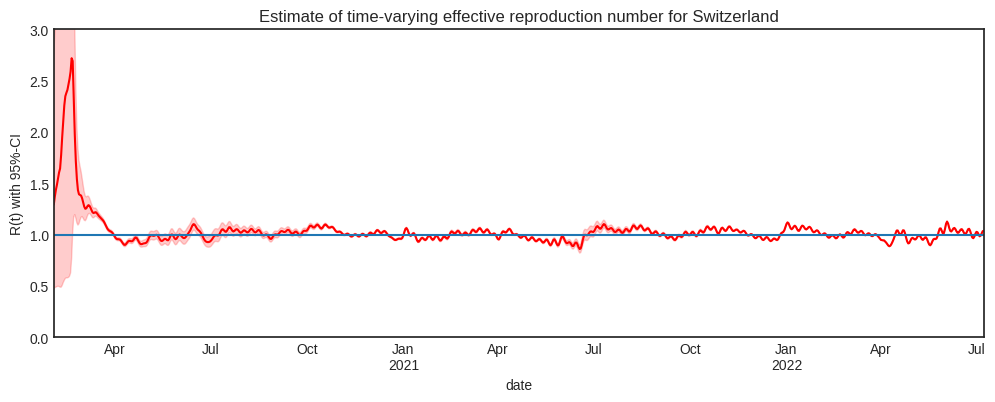

In [176]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))

ch_time_varying_r.loc[:,'Q0.5'].plot(ax=ax, color='red')
ax.fill_between(ch_time_varying_r.index,
                    ch_time_varying_r['Q0.025'],
                    ch_time_varying_r['Q0.975'],
                    color='red', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
ax.set_ylim([0,3])
ax.axhline(y=1)
ax.set_title('Estimate of time-varying effective reproduction number for Switzerland')
plt.show()

#For Italy

In [177]:
ch_cases = pd.DataFrame()
ch_cases['Date'] = df['date']
ch_cases['Cases'] = df['new_cases']
ch_cases['Location'] = df['location']
ch_cases = ch_cases.loc[(ch_cases['Location'] == 'Italy')]
ch_cases = ch_cases.drop(columns='Location')
ch_cases = ch_cases.dropna()
ch_cases['Cases'] = ch_cases['Cases'].astype(int)
ch_cases = ch_cases.set_index('Date')['Cases']
ch_cases

Date
2020-01-31         2
2020-02-01         0
2020-02-02         0
2020-02-03         0
2020-02-04         0
               ...  
2022-07-09     98901
2022-07-10     81563
2022-07-11     83761
2022-07-12    144058
2022-07-13    111591
Name: Cases, Length: 894, dtype: int64

Смотрим среднее, дисперсию, квантили

In [178]:
ch_time_varying_r = r_covid(ch_cases)

ch_time_varying_r.tail()

,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2022-07-04,36885.0,1.026931,0.000003,1.023331,1.026930,1.030538
2022-07-05,133015.0,1.020080,0.000003,1.016531,1.020078,1.023634
2022-07-06,110017.0,1.018721,0.000003,1.015208,1.018720,1.022239
2022-07-07,108386.0,1.022586,0.000003,1.019102,1.022585,1.026076
2022-07-08,101863.0,1.024880,0.000003,1.021429,1.024879,1.028337


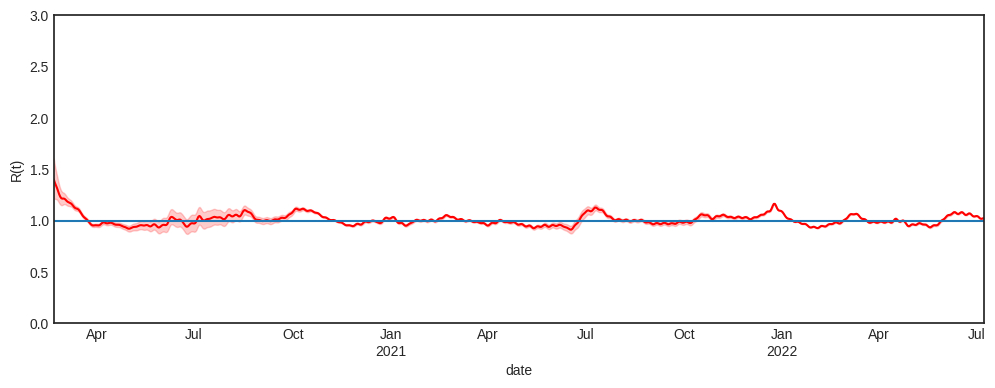

In [181]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))

ch_time_varying_r.loc[:,'Q0.5'].plot(ax=ax, color='red')
ax.fill_between(ch_time_varying_r.index,
                    ch_time_varying_r['Q0.025'],
                    ch_time_varying_r['Q0.975'],
                    color='red', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('R(t)')
ax.set_ylim([0,3])
ax.axhline(y=1)
plt.show()